---
title: "Breast Cancer Analysis"
author: "John Torres"
date: "2023-10-05"
format: html
code-fold: false
description: "An analysis of breast cancer data using Python."
---

# Import the Dataset from Kaggle Using API Key

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.model_selection import GridSearchCV
import os
from decouple import config
import os
import kagglehub
import math
import shap
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

KAGGLE_USER = config("KAGGLE_USER")
KAGGLE_KEY= config("KAGGLE_KEY")

# Download latest version of the dataset
path = kagglehub.dataset_download("yasserh/breast-cancer-dataset")

print("Path to dataset files:", path)

# List files in the dataset directory
print("Files in dataset:", os.listdir(path))

# Get file name
file_path = os.path.join(path, "breast-cancer.csv")
df = pd.read_csv(file_path)

# Convert the target variable to binary (M: 1, B: 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Display first few rows
print(df.head())

Path to dataset files: /Users/johntorres/.cache/kagglehub/datasets/yasserh/breast-cancer-dataset/versions/1
Files in dataset: ['breast-cancer.csv']
         id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1        17.99         10.38          122.80     1001.0   
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
3  84348301          1        11.42         20.38           77.58      386.1   
4  84358402          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414           

# Dataset Evaluation

In [6]:
# Check for missing values
print("Missing Values in Dataset:")
print(df.isnull().sum())

Missing Values in Dataset:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


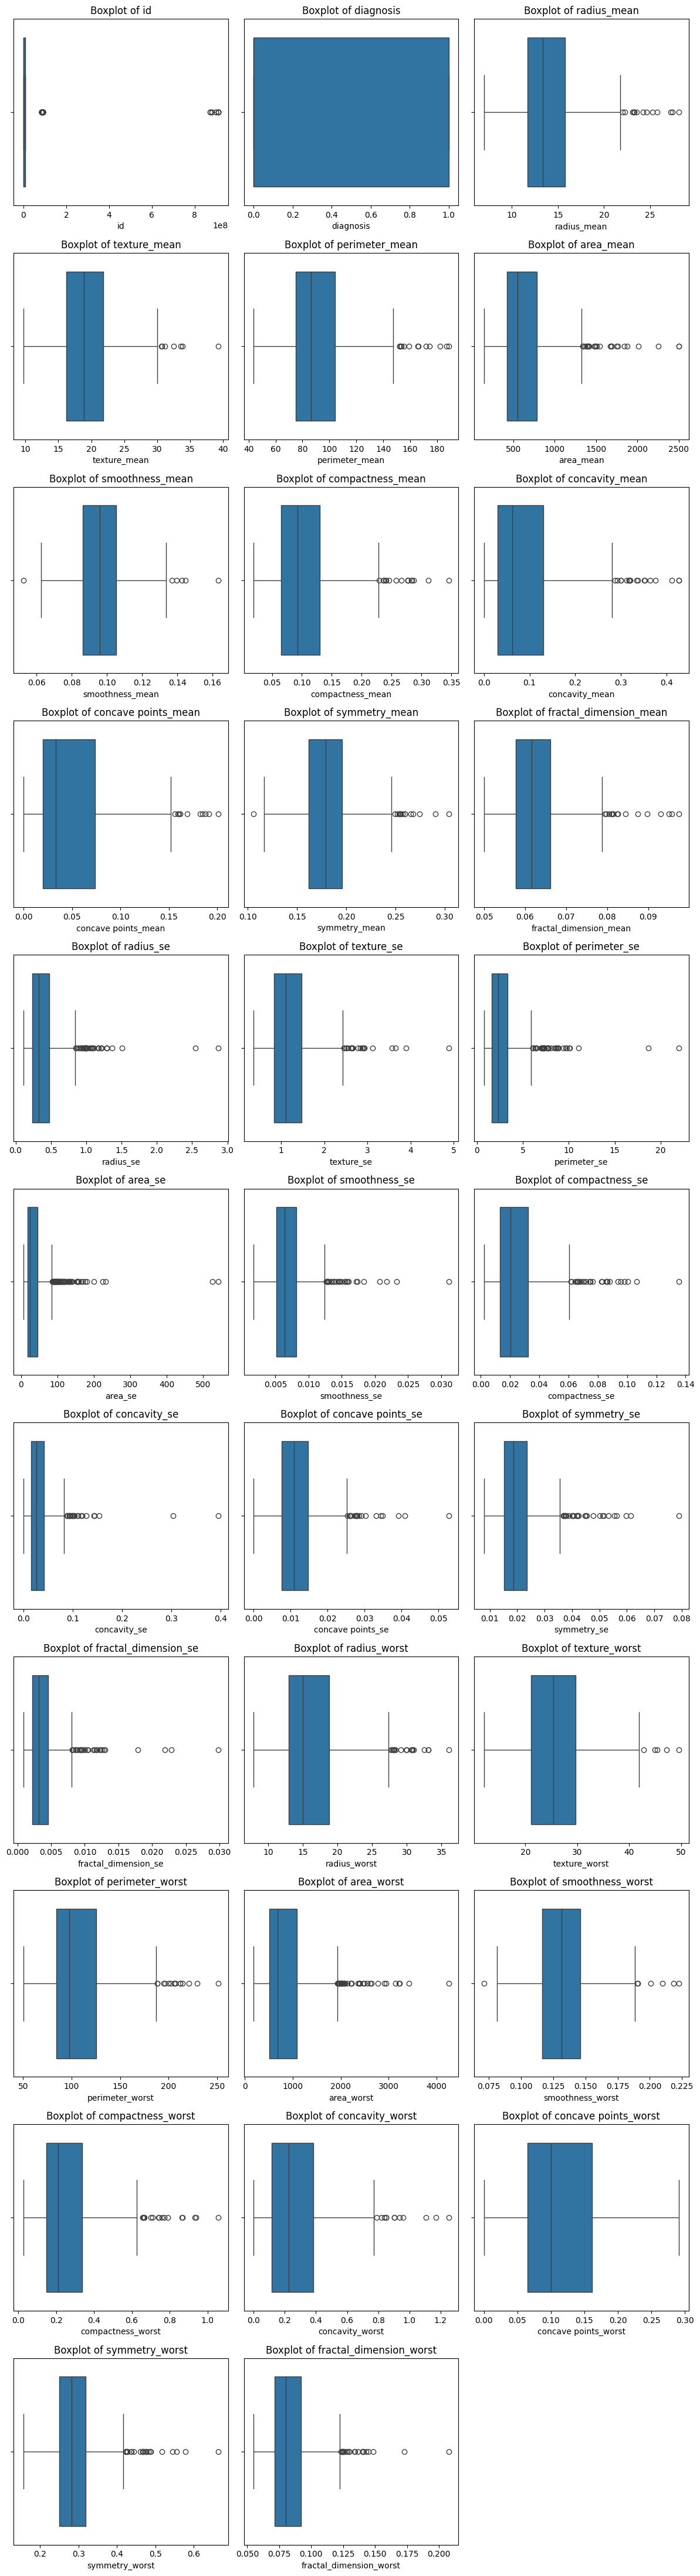

In [7]:
# Boxplots for numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns needed for the subplots
n_cols = 3
n_rows = math.ceil(len(numerical_features) / n_cols)

plt.figure(figsize=(12, 4 * n_rows))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [149]:
# Remove 'id' and 'diagnosis' columns from features
feature_cols = [col for col in df.columns if col not in ['diagnosis', 'id']]

# Calculate IQR for each feature
Q1 = df[feature_cols].quantile(0.25)
Q3 = df[feature_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create an empty list to store the outliers count for each feature
outliers_list = []

# Loop through each feature and count the number of outliers
for feature in feature_cols:
    # Identify outliers for each feature
    outlier_count = ((df[feature] < lower_bound[feature]) | (df[feature] > upper_bound[feature])).sum()
    outliers_list.append({'Feature': feature, 'Outliers Count': outlier_count})

# Convert the list to a DataFrame for easy display
outliers = pd.DataFrame(outliers_list)

# Sort the DataFrame by feature name (alphabetical order)
outliers_sorted_feature = outliers.sort_values(by='Feature', ascending=True)

# Sort the DataFrame by feature name (alphabetical order)
outliers_sorted_cnt = outliers.sort_values(by='Outliers Count', ascending=True)

# Display the table of outliers
print("Outliers sorted A-Z:")
print(outliers_sorted_feature)

# Display the table of outliers
print("Outliers sorted by Count Acs:")
print(outliers_sorted_cnt)

Outliers sorted A-Z:
                    Feature  Outliers Count
3                 area_mean               7
13                  area_se               2
23               area_worst               2
5          compactness_mean              16
15           compactness_se              26
25        compactness_worst              16
7       concave points_mean              10
17        concave points_se              19
27     concave points_worst               0
6            concavity_mean              18
16             concavity_se              22
26          concavity_worst              12
9    fractal_dimension_mean              15
19     fractal_dimension_se              28
29  fractal_dimension_worst              24
2            perimeter_mean              13
12             perimeter_se               2
22          perimeter_worst              15
0               radius_mean               5
10                radius_se              13
20             radius_worst              17
4          

## Log Transformation and Extreme Values Removal

In [147]:
# Apply log transformation to skewed features (example: area_se, radius_se, perimeter_se)
log_transformed_features = ['area_se', 'radius_se', 'perimeter_se', 'area_mean', 'radius_mean']  # Add more as needed
for feature in log_transformed_features:
    df[feature] = np.log1p(df[feature])  # log1p to avoid log(0)

# Calculate IQR for outlier detection
Q1 = df[log_transformed_features].quantile(0.25)
Q3 = df[log_transformed_features].quantile(0.75)
IQR = Q3 - Q1

# Identify and remove outliers for each feature using the IQR method
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers in each feature
df_cleaned = df.copy()  # Make a copy to clean the data without modifying the original
for feature in log_transformed_features:
    df_cleaned = df_cleaned[(df_cleaned[feature] >= lower_bound[feature]) & (df_cleaned[feature] <= upper_bound[feature])]

# Display the cleaned data (for review)
print(df_cleaned.shape)  # Print the shape to see how many rows were removed
print(df_cleaned.head())

(550, 32)
         id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1     1.372173         10.38          122.80   2.068097   
1    842517          1     1.403963         17.77          132.90   2.102996   
2  84300903          1     1.393680         21.25          130.00   2.091049   
3  84348301          1     1.258264         20.38           77.58   1.939990   
4  84358402          1     1.400749         14.34          135.10   2.100295   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter

In [143]:
from scipy.stats import mstats

# List of features to apply the log transformation and winsorization
log_transformed_features = [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
    'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 
    'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 
    'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 
    'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 
    'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 
    'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

# Apply log transformation to the specified features
for feature in log_transformed_features:
    df[feature] = np.log1p(df[feature])

# Apply winsorization for extreme outliers (top and bottom 5%)
for feature in log_transformed_features:
    df[feature] = mstats.winsorize(df[feature], limits=[0, 0.05])  # Limiting top 5% and bottom 5%

# Calculate IQR for outlier detection after winsorization
Q1 = df[log_transformed_features].quantile(0.25)
Q3 = df[log_transformed_features].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on IQR method
df_cleaned = df.copy()  # Make a copy to clean the data without modifying the original
for feature in log_transformed_features:
    df_cleaned = df_cleaned[(df_cleaned[feature] >= lower_bound[feature]) & (df_cleaned[feature] <= upper_bound[feature])]

# Display the cleaned data (for review)
print(df_cleaned.shape)  # Print the shape to see how many rows were removed
print(df_cleaned.head())

(535, 32)
         id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1     1.372173      2.431857        4.818667   2.068097   
1    842517          1     1.403963      2.932260        4.897093   2.101608   
2  84300903          1     1.393680      3.102342        4.875197   2.091049   
3  84348301          1     1.258264      3.062456        4.364117   1.939990   
4  84358402          1     1.400749      2.730464        4.913390   2.100295   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0         0.111899          0.189545        0.218252             0.118583   
1         0.081340          0.075701        0.083330             0.067818   
2         0.104000          0.148334        0.180153             0.118583   
3         0.112346          0.189545        0.216240             0.100026   
4         0.095583          0.124692        0.180653             0.099212   

   ...  radius_worst  texture_worst  perimeter

## New Boxplots (Post-Transformation)

In [137]:
print("Original data shape:", df.shape)
print("Cleaned data shape:", df_cleaned.shape)

# Summary statistics before cleaning
print("Summary statistics before cleaning:")
print(df.describe())

# Summary statistics after cleaning
print("Summary statistics after cleaning:")
print(df_cleaned.describe())

Original data shape: (569, 32)
Cleaned data shape: (485, 32)
Summary statistics before cleaning:
                 id   diagnosis  radius_mean  texture_mean  perimeter_mean  \
count  5.690000e+02  569.000000   569.000000    569.000000      569.000000   
mean   3.037183e+07    0.372583     2.691235     19.289649       91.969033   
std    1.250206e+08    0.483918     0.222226      4.301036       24.298981   
min    8.670000e+03    0.000000     2.077064      9.710000       43.790000   
25%    8.692180e+05    0.000000     2.541602     16.170000       75.170000   
50%    9.060240e+05    0.000000     2.665143     18.840000       86.240000   
75%    8.813129e+06    1.000000     2.820188     21.800000      104.100000   
max    9.113205e+08    1.000000     3.371082     39.280000      188.500000   

        area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count  569.000000       569.000000        569.000000      569.000000   
mean     6.365109         0.096360          0.104341    

# Descriptive Statistics

In [121]:
# Descriptive Statistics
print("Dataset Overview:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimete

## Exploratory Data Analysis (EDA)

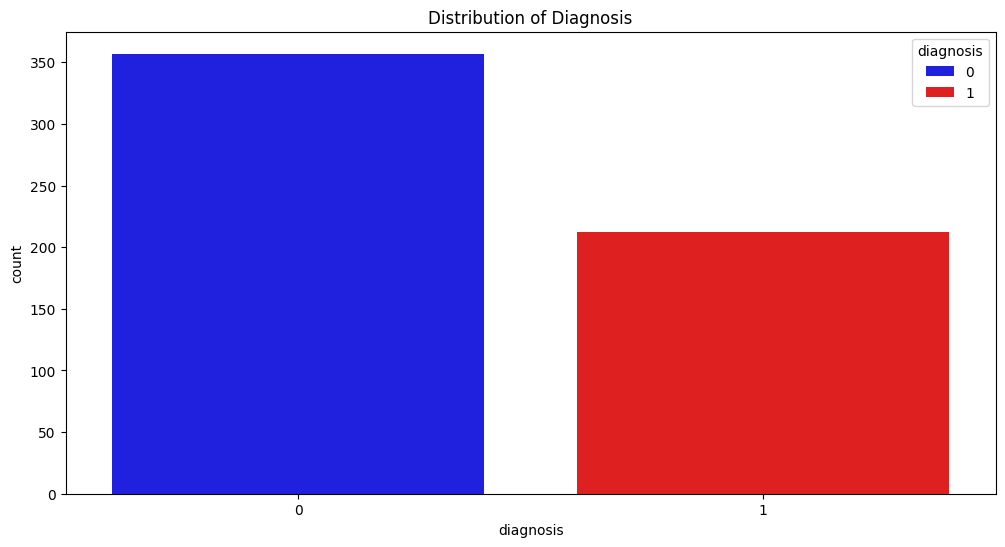

In [119]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='diagnosis', hue='diagnosis', palette={1: 'red', 0: 'blue'})
plt.title('Distribution of Diagnosis')
plt.show()

## Correlation Heatmap

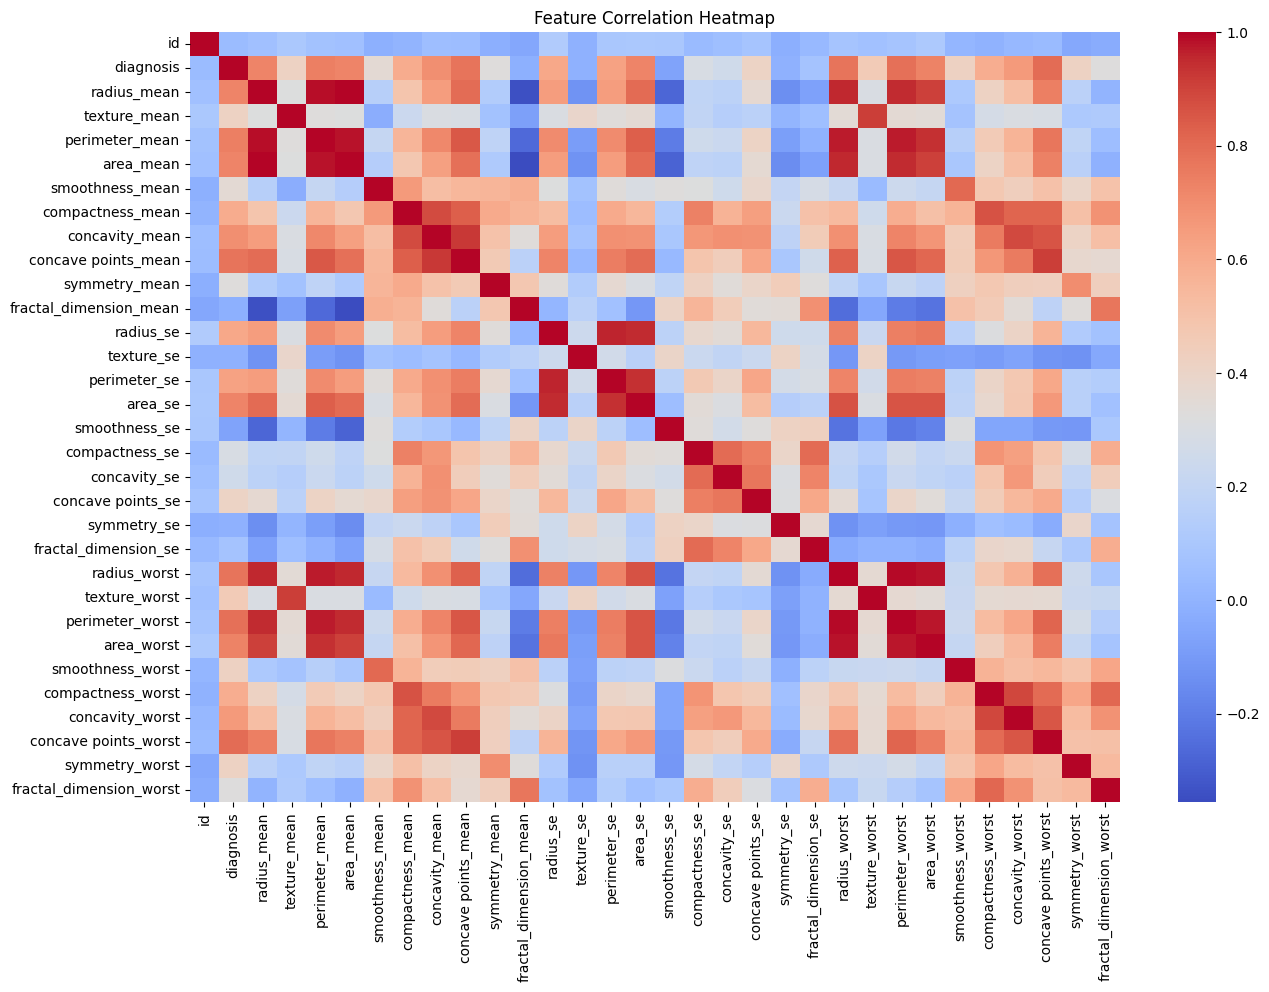

In [123]:
# Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### Correlation Matrix

In [115]:
# Compute the correlation matrix
correlation_matrix = X.corr()

# Display the correlation matrix as a table
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                         radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean                 1.000000      0.323782        0.997855   0.987357   
texture_mean                0.323782      1.000000        0.329533   0.321086   
perimeter_mean              0.997855      0.329533        1.000000   0.986507   
area_mean                   0.987357      0.321086        0.986507   1.000000   
smoothness_mean             0.170581     -0.023389        0.207278   0.177028   
compactness_mean            0.506124      0.236702        0.556936   0.498502   
concavity_mean              0.676764      0.302418        0.716136   0.685983   
concave points_mean         0.822529      0.293464        0.850977   0.823269   
symmetry_mean               0.147741      0.071401        0.183027   0.151293   
fractal_dimension_mean     -0.311631     -0.076437       -0.261477  -0.283110   
radius_se                   0.679090      0.275869        0.691765   0.732562   
texture_

### Correlation Matrix
(This will help to determine which variables to drop to avoid multicollinearity)

In [117]:
# Optional: Sort the correlation matrix for easier analysis
sorted_correlation_matrix = correlation_matrix.unstack().sort_values(ascending=False)

# Display the sorted correlation matrix (ignoring self-correlations, which are always 1)
sorted_correlation_matrix = sorted_correlation_matrix[sorted_correlation_matrix != 1]
print("\nSorted Correlation Matrix (excluding self-correlations):")
print(sorted_correlation_matrix)


Sorted Correlation Matrix (excluding self-correlations):
perimeter_mean          radius_mean               0.997855
radius_mean             perimeter_mean            0.997855
radius_worst            perimeter_worst           0.993708
perimeter_worst         radius_worst              0.993708
radius_mean             area_mean                 0.987357
                                                    ...   
fractal_dimension_mean  perimeter_mean           -0.261477
                        area_mean                -0.283110
area_mean               fractal_dimension_mean   -0.283110
radius_mean             fractal_dimension_mean   -0.311631
fractal_dimension_mean  radius_mean              -0.311631
Length: 870, dtype: float64


# Question 1: Can we accurately predict malignancy?

In [84]:
# Define feature columns (all except 'diagnosis' and 'id')
feature_cols = [col for col in df.columns if col not in ['diagnosis', 'id']]

# Dropping highly correlated variables to avoid multicollinearity
# 'perimeter_mean' and 'radius_mean' are highly correlated (0.997855), so we keep one of them. Dropping 'perimeter_mean'.
feature_cols.remove('perimeter_mean')

# 'radius_worst' and 'perimeter_worst' are highly correlated (0.993708), so we keep one of them. Dropping 'perimeter_worst'.
feature_cols.remove('perimeter_worst')

# 'radius_mean' and 'area_mean' are highly correlated (0.987357), so we keep one of them. Dropping 'area_mean'.
feature_cols.remove('area_mean')

# 'radius_worst' and 'area_worst' are highly correlated (0.974513), so we keep one of them. Dropping 'area_worst'.
feature_cols.remove('area_worst')

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Question 1: Can we accurately predict malignancy? ---
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Model Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))

# --- Hyperparameter Tuning: Logistic Regression ---
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}
grid_search_log_reg = GridSearchCV(LogisticRegression(), param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train_scaled, y_train)
print(f"Best Parameters for Logistic Regression: {grid_search_log_reg.best_params_}")
print(f"Best Cross-Validation Accuracy for Logistic Regression: {grid_search_log_reg.best_score_}")

# Re-train Logistic Regression with Best Parameters
best_log_reg = grid_search_log_reg.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)
y_pred_log_best = best_log_reg.predict(X_test_scaled)

# Re-evaluate the Logistic Regression after tuning
print(" ")
print("Logistic Regression Performance (After Tuning):")
print(classification_report(y_test, y_pred_log_best))

# --- LIME Explanation for Logistic Regression ---
explainer_log = LimeTabularExplainer(X_train_scaled, training_labels=y_train, feature_names=feature_cols, class_names=['Benign', 'Malignant'], discretize_continuous=True)
idx = 0  # Index for the instance you want to explain (you can change this as needed)
exp_log = explainer_log.explain_instance(X_test_scaled[idx], best_log_reg.predict_proba, num_features=10)

# Show explanation for Logistic Regression
print("LIME Explanation for Logistic Regression:")
exp_log.show_in_notebook()

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best Cross-Validation Accuracy for Logistic Regression: 0.9736263736263737
 
Logistic Regression Performance (After Tuning):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

LIME Explanation for Logistic Regression:


# Question 2: Which features influence malignancy risk the most?

In [72]:
# --- Question 2: Which features influence malignancy risk the most? ---

feature_importance_log = pd.DataFrame({'Feature': feature_cols, 'Importance': np.abs(log_reg.coef_[0])})
feature_importance_log = feature_importance_log.sort_values(by='Importance', ascending=False)
print("Top Features Affecting Malignancy:")
print(feature_importance_log.head(10))

Top Features Affecting Malignancy:
                Feature  Importance
22        texture_worst    1.428289
11            radius_se    1.245725
29       symmetry_worst    1.050745
8   concave points_mean    0.966908
27      concavity_worst    0.914354
16       compactness_se    0.912136
14              area_se    0.906928
24           area_worst    0.893980
21         radius_worst    0.892894
7        concavity_mean    0.782857


# Question 3: Estimated probability of malignancy

In [59]:
# --- Question 3: Estimated probability of malignancy ---
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
df_prob = pd.DataFrame({'Actual': y_test, 'Predicted Probability': y_prob})
print("Probability Estimates:")
print(df_prob.head(10))

Probability Estimates:
     Actual  Predicted Probability
120       0               0.000360
250       1               1.000000
375       0               0.041989
99        1               0.570044
455       0               0.511129
318       0               0.000613
39        1               0.768374
371       0               0.000994
98        0               0.000578
502       0               0.009980


# Question 4: Compare Logistic Regression with Random Forest

In [74]:
# --- Question 4: Compare Logistic Regression with Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Performance Comparison
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# --- Hyperparameter Tuning: Random Forest ---
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best Cross-Validation Accuracy for Random Forest: {grid_search_rf.best_score_}")

# Re-train Random Forest with Best Parameters
best_rf_clf = grid_search_rf.best_estimator_
best_rf_clf.fit(X_train, y_train)
y_pred_rf_best = best_rf_clf.predict(X_test)

# Re-evaluate the Random Forest after tuning
print("Random Forest Performance (After Tuning):")
print(classification_report(y_test, y_pred_rf_best))

# Feature Importance from Random Forest
feature_importance_rf = pd.DataFrame({'Feature': feature_cols, 'Importance': best_rf_clf.feature_importances_})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print("Top Features in Random Forest:")
print(feature_importance_rf.head(10))

# --- Model Validation & Reliability ---
cv_scores_log = cross_val_score(best_log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_scores_rf = cross_val_score(best_rf_clf, X_train, y_train, cv=5, scoring='accuracy')

print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(cv_scores_log):.4f}")
print(f"Random Forest Cross-Validation Accuracy: {np.mean(cv_scores_rf):.4f}")

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

Best Parameters for Random Forest: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 150}
Best Cross-Validation Accuracy for Random Forest: 0.9626373626373628
Random Forest Performance (After Tuning):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

Top Features in Random Forest:
                 Feature  Importance
23       perimeter_worst    0.165625
28  c